In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import missingno as msno
import plotly.express as px # plotting geo data
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import autofeat
import osmnx as ox
import geopandas as gpd

from Own_imputers import PriorityGroupImputer
from OwnFeatEng import feature_engineering, feature_selection, add_geo_features_optimized
from OwnDimRed import PCA_num

# Train

## Data

In [2]:
data = pd.read_csv("train.csv", header=0)
data = data.drop(columns=['is_promoted','sticker','price_drop_date'])

train, test = train_test_split(data,test_size=0.2, shuffle=True)

In [3]:
type_map = {
    'energy_label': 'category',
    'postcode': 'category',
    'advertiser' : 'category',
    'province' : 'category', 
    'house_type' : 'category',
    'subtype' : 'category',
    'new_building': 'bool'
}

house_map = {
    'Apartments & Flats': [
        'Appartement', 'Gelijkvloers app.', 'Duplex', 'Triplex', 'Dakappartement',
        'Penthouse', 'Serviceflat', 'Assistentie-appartement', 'Studio', 'Studio met slaaphoek', 
        'App. vrij beroep', 'Appartementsgebouw'
    ],
    'Single-Family Houses': [
        'Eengezinswoning', 'Woning', 'Villa', 'Villa-landhuis', 'Moderne villa',
        'Cottage', 'Bungalow', 'Koppelwoning', 'Koppelvilla', 'Hoekwoning', 'Rijwoning', 'Bel-étage', 'Burgerswoning'
    ],
    'Historical & Luxurious Homes': [
        'Herenhuis', 'Herenwoning', 'Uitzonderlijke woning', 'Kasteel', 'Pastorijwoning'
    ],
    'Farm & Rural Houses': [
        'Hoeve', 'Boerderij', 'Fermette', 'Chalet'
    ],
    'Mixed-Use & Unique Properties': [
        'Gemengd gebruik', 'Arbeiderswoning', 'Kangoeroewoning', 'Woonboot', 'Loft',
        'Split-level', 'Patio woning', 'Buitenverblijf', 'Vakantiewoning'
    ]
}

# Function to categorize houses
def categorize_house(house_type):
    for category, types in house_map.items():
        if house_type in types:
            return category
    return 'Other'

postcode_list = pd.read_csv("BE.txt", sep="\t", header=None)[[1,9,10]]
postcode_list.columns = ['postcode','lat','lon']
postcode_list['postcode']=postcode_list['postcode'].astype('category')
postcode_list = postcode_list.groupby('postcode', observed=False)[['lat','lon']].mean()

class preprocess:
    def __init__(self, postcode_source=None, type_map = {}):
        self.subtype_imputer = PriorityGroupImputer(target_cols=['subtype'], priority_groups = {1:['bedrooms_cat']}, strategy = 'mode')
        self.geo_imputer = PriorityGroupImputer(target_cols=['lat','lon'], priority_groups = {1:['postcode']}, strategy = 'external', data_source=postcode_source)
        self.clf_geo = EllipticEnvelope(contamination=0.0002, support_fraction=0.9)
        self.clf_area = EllipticEnvelope(contamination=0.0002, support_fraction=0.9)
        self.area_imputer = PriorityGroupImputer(target_cols=['area'], priority_groups = {1:['bedrooms_cat','house_type'], 2:['bedrooms_cat']}, strategy = 'median')
        self.ev_imputer_median = PriorityGroupImputer(target_cols=['energy_value'], priority_groups = {1:['energy_label','province']}, strategy = 'median', fallback=True)
        self.type_map = type_map
        self.belgium_polygon = ox.geocode_to_gdf("Belgium").geometry.iloc[0]
    
    def missing_checker(self, df):
            missing_values = round(df.isna().sum()/len(df)*100,2)
            missing_checker_df = df.isna()*1
            missing_checker_df = missing_checker_df.drop(columns=missing_values.index[missing_values==0].tolist())
            missing_checker_df = missing_checker_df.add_suffix('_miss')
            missing_checker_df = (missing_checker_df==1)
            return missing_checker_df

    def train(self, df):
        missing = self.missing_checker(df)
        
        df['bedrooms_cat'] = pd.cut(df['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
        df['house_type'] = df['subtype'].apply(categorize_house)

        df = self.subtype_imputer.fit_transform(df)

        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df['lon'], df['lat']),
            crs="EPSG:4326"
            )
        in_belgium_mask = gdf.geometry.within(self.belgium_polygon)
        df['lat'] = np.where(in_belgium_mask, df['lat'], np.nan)
        df['lon'] = np.where(in_belgium_mask, df['lon'], np.nan)

        df = self.geo_imputer.fit_transform(df)

        # outliers_geo = self.clf_geo.fit_predict(df[['lat','lon']])
        # df['lat'] = df['lat'].where((df['lat']<52) & (df['lat']>49), np.nan)
        # df['lon'] = df['lon'].where((df['lon']<8) & (df['lat']>2), np.nan)
        
        # df = self.geo_imputer.transform(df)


        outliers_area = self.clf_area.fit_predict(df[['area']].dropna())
        df['area'] = df['area'].where(~df['id'].isin(df[['area','id']].dropna()[outliers_area==-1]['id']), np.nan)
        df = self.area_imputer.fit_transform(df)
        
        df = self.ev_imputer_median.fit_transform(df)
        
        df = pd.concat([df, missing], axis=1)
        df['advertiser'] = df['advertiser'].fillna('Other')

        df = df.astype(self.type_map)
        return df

    def test(self, df):   
        missing = self.missing_checker(df)
        
        df['bedrooms_cat'] = pd.cut(df['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
        df['house_type'] = df['subtype'].apply(categorize_house)

        df = self.subtype_imputer.transform(df)
        
        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df['lon'], df['lat']),
            crs="EPSG:4326"
            )
        
        in_belgium_mask = gdf.geometry.within(self.belgium_polygon)
        df['lat'] = np.where(in_belgium_mask, df['lat'], np.nan)
        df['lon'] = np.where(in_belgium_mask, df['lon'], np.nan)

        df = self.geo_imputer.transform(df)
        
        # outliers_geo = self.clf_geo.predict(df[['lat','lon']])
        # df['lat'] = df['lat'].where((df['lat']<52) & (df['lat']>49), np.nan)
        # df['lon'] = df['lon'].where((df['lon']<8) & (df['lat']>2), np.nan)
        # df = self.geo_imputer.transform(df)

        outliers_area = self.clf_area.predict(df[['area']].dropna())
        df['area'] = df['area'].where(~df['id'].isin(df[['area','id']].dropna()[outliers_area==-1]['id']), np.nan)
        df = self.area_imputer.transform(df)
        
        df = self.ev_imputer_median.transform(df)
        
        df = pd.concat([df, missing], axis=1)
        df['advertiser'] = df['advertiser'].fillna('Other')

        df = df.astype(self.type_map)
        return df

In [4]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='price'),train['price'], shuffle=True, test_size=0.2)
prep = preprocess(postcode_source=postcode_list, type_map=type_map)
X_train = prep.train(X_train).reset_index(drop=True)
X_val = prep.test(X_val).reset_index(drop=True)

## Feature engineering

In [5]:
features_init = (['house_type',
             'bedrooms', 'area',
             'new_building', 'lat', 'lon', 'foto_amount',
             'energy_value', 
             'area_miss',  'energy_value_miss'])
# 'province', advertiser','advertiser_miss', 'lat_miss',  'subtype_miss', 'is_appartment', 

### loading geodata

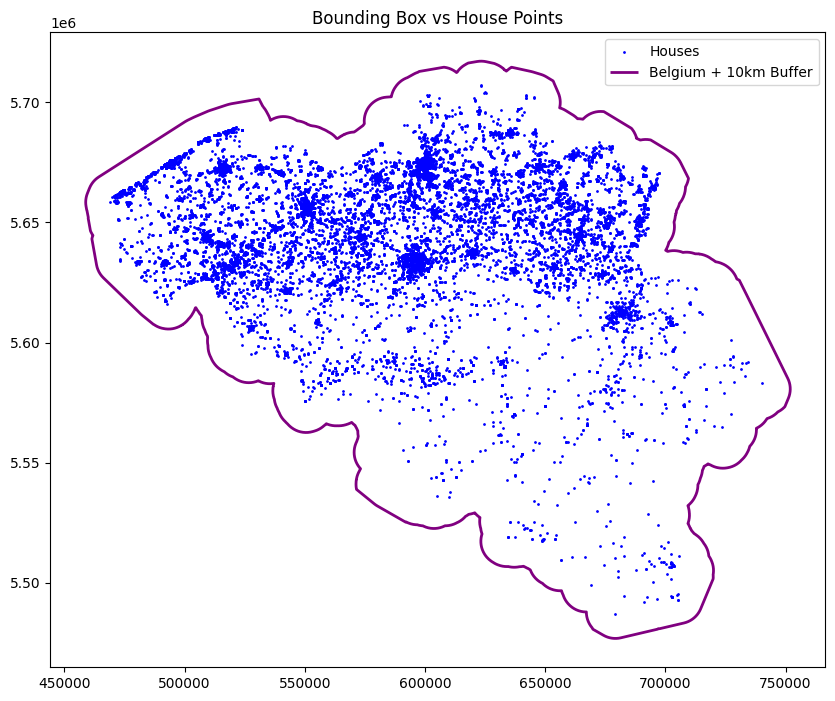

In [6]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, box

# Step 1: Convert to GeoDataFrame
gdf_houses = gpd.GeoDataFrame(
    X_train,
    geometry=[Point(xy) for xy in zip(X_train['lon'], X_train['lat'])],
    crs="EPSG:4326"
)

# Step 2: Project to UTM
utm_crs = gdf_houses.estimate_utm_crs()
gdf_houses = gdf_houses.to_crs(utm_crs)

# Step 3: Define bounding box with buffer

# belgium = ox.geocode_to_gdf("Belgium").to_crs(utm_crs)
# belgium_buffered = belgium.geometry.iloc[0].buffer(10000)
# belgium_buffered_gdf = gpd.GeoDataFrame(geometry=[belgium_buffered], crs=gdf_houses.crs)

# custom_polygon = gdf_houses.union_all().convex_hull.buffer(10000)
# custom_polygon_gdf = gpd.GeoDataFrame(geometry=[custom_polygon], crs=gdf_houses.crs)

# intersection_gdf = gpd.overlay(belgium_buffered_gdf, custom_polygon_gdf, how="intersection")

intersection_gdf = gpd.read_file('intersection_gdf_espg4326.gpkg').to_crs(utm_crs)

# Step 5: Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_houses.plot(ax=ax, color='blue', markersize=1, label='Houses')

#belgium_buffered_gdf.boundary.plot(
#     ax=ax, color='green', linewidth=2, label='Belgium + 10km Buffer'
# )
#custom_polygon_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Bounding Box')

intersection_gdf.boundary.plot(
    ax=ax, color='purple', linewidth=2, label='Belgium + 10km Buffer'
)
plt.legend()
plt.title("Bounding Box vs House Points")
plt.show()

intersection_gdf_espg4326 = intersection_gdf.to_crs("EPSG:4326").geometry.iloc[0]

In [7]:
intersection_gdf.area/1e6

0    40752.171982
dtype: float64

In [8]:
# 1 priority
useamenity = ["restaurant", "fast_food", "cafe", "bar", "pub", 'nightclub' ,'stripclub', 'internet_cafe',
                "college", 'kindergarten', 'library', 'research_institute', 'music_school' , 'school', 'university', 'driving_school', 'traffic_park', 'driver_training',
                'bus_station', 'taxi',
                'bank',
                'clinic', 'dentist ' ,'doctors','hospital','nursing_home', 'pharmacy', 'social_facility', 'veterinary',
                'arts_centre','brothel','casino','cinema','community_centre','conference_centre','events_venue','exhibition_centre','fountain','gambling','music_venue',
                'planetarium','social_centre', 'stage', 'theatre',
                'courthouse', 'fire_station' ,'police', 'prison', 'townhall',
                'crematorium','funeral_hall','grave_yard','mortuary',
                'charging_station', 'fuel']
area_calc = []
tag_amenity = {'amenity': True}
tag_shop = {'shop': True}
tag_leisure = {'leisure': True}
tag_tourism = {'tourism': True}
tag_landuse = {'landuse': True}
tag_natural = {'natural': True}

In [9]:
# gdf_natural= ox.features.features_from_polygon(intersection_gdf_espg4326, tags=tag_natural) #[['geometry','landuse']]
# gdf_natural[['geometry','natural']].to_file("gdf_natural.gpkg", driver="GPKG")
# print(gdf_natural.head())

In [10]:
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_tourism.plot(
#     ax=ax, color='purple', markersize=1
# )
# gdf_houses.to_crs(gdf_tourism.crs).plot(ax=ax, color='blue', markersize=1, label='Houses')
# plt.show()

In [11]:
# gdf_tourism.to_file("gdf_tourism.gpkg", driver="GPKG")

In [12]:
# valid_in_any_group = (
#     gdf_landuse.groupby('amenity')
#     .apply(lambda g: ~g.isna().any(), include_groups=False) 
#     .any(axis=0)                       
# )

In [13]:
# valid_in_any_group

### features from geodata


In [14]:
gdf_leisure = gpd.read_file('gdf_leisure.gpkg')

In [15]:
leisure_features = gdf_leisure.groupby('leisure')['geometry'].count()[(gdf_leisure.groupby('leisure')['geometry'].count()>25)]
print(leisure_features)

leisure
adult_gaming_centre       32
amusement_arcade          61
bandstand                166
barefoot                  44
bird_hide                369
bleachers                145
bowling_alley             74
common                   635
dance                    159
dog_park                 728
escape_game               71
firepit                  120
fishing                  361
fitness_centre           756
fitness_station         1152
garden                 32219
golf_course              250
hackerspace               34
horse_riding             512
marina                   174
miniature_golf           209
nature_reserve          1582
outdoor_seating         1836
park                    7874
picnic_table           11383
pitch                  26571
playground              9921
recreation_ground         77
resort                    56
sauna                    128
schoolyard               275
slipway                  285
sports_centre           4266
sports_hall              451
stadiu

In [17]:
X_try  = X_train.iloc[:100]
gdf_houses_espg4326 = gpd.GeoDataFrame(
    X_train,
    geometry=[Point(xy) for xy in zip(X_train['lon'], X_train['lat'])],
    crs="EPSG:4326"
)
park_features =add_geo_features_optimized(gdf_houses_espg4326, gdf_leisure, 'leisure', 'park', [500, 1000, 1500, 2000], 10000, True)

Building spatial index...


100%|██████████| 17324/17324 [00:55<00:00, 312.10it/s]


In [22]:
gdf_houses_val_espg4326 = gpd.GeoDataFrame(
    X_val,
    geometry=[Point(xy) for xy in zip(X_val['lon'], X_val['lat'])],
    crs="EPSG:4326"
)
park_features_val =add_geo_features_optimized(gdf_houses_val_espg4326, gdf_leisure, 'leisure', 'park', [500, 1000, 1500, 2000], 10000, True)

Building spatial index...


100%|██████████| 4332/4332 [00:12<00:00, 346.24it/s]


In [20]:
geofeatcols = park_features.columns[park_features.columns.get_loc('geometry') + 1:].to_list()

In [21]:
geofeatcols

['closest_leisure*park',
 'median_leisure*park_500',
 'median_leisure*park_1000',
 'median_leisure*park_1500',
 'median_leisure*park_2000',
 'mean_leisure*park_500',
 'mean_leisure*park_1000',
 'mean_leisure*park_1500',
 'mean_leisure*park_2000',
 'count_leisure*park_500',
 'count_leisure*park_1000',
 'count_leisure*park_1500',
 'count_leisure*park_2000',
 'total_area_leisure*park_500',
 'total_area_leisure*park_1000',
 'total_area_leisure*park_1500',
 'total_area_leisure*park_2000']

### New own features

In [ ]:
# from OwnFeatEng import SpecialTransform

# new_cols = SpecialTransform(X_train).columns.to_list()
# X_train = X_train.join(SpecialTransform(X_train))
# X_val = X_val.join(SpecialTransform(X_val))

In [ ]:
# cl_range = list(range(20,101,20)) + list(range(150,301,50))
# feateng = feature_engineering(targets=['area', 'bedrooms','energy_value'],
#                               transform_type=['median'],
#                               comp_type=['diff'],
#                               groups=['province','house_type'],
#                               features=['lat','lon'],
#                               cl_name='clt',
#                               clustering=True, 
#                               cluster_range=cl_range)

# feateng_density = feature_engineering(targets=['area'],
#                               transform_type=['count'],
#                               comp_type=None,
#                               groups=['province','house_type'],
#                               features=['lat','lon'],
#                               cl_name='clt',
#                               clustering=False, 
#                               cluster_range=cl_range)

# X_train_new = feateng.train(X_train)
# X_val_new = feateng.test(X_val)


# X_train_new = feateng_density.train(X_train_new)
# X_val_new = feateng_density.test(X_val_new)

In [ ]:
# X_train_new.columns

Index(['id', 'is_appartment', 'area', 'added_time', 'bedrooms', 'new_building',
       'postcode', 'lat', 'lon', 'advertiser',
       ...
       'area-clt40-count', 'area-clt60-count', 'area-clt80-count',
       'area-clt100-count', 'area-clt150-count', 'area-clt200-count',
       'area-clt250-count', 'area-clt300-count', 'area-province-count',
       'area-house_type-count'],
      dtype='object', length=110)

In [ ]:
# features_new = X_train_new.columns.to_list()[24:]
# print(len(features_new))

86


### Feature selection on correlation

In [14]:
def getnum(df):
    logic = (df.dtypes=='float64') | (df.dtypes=='float32') | (df.dtypes=='float16')
    num_features = df.dtypes[logic].index.to_list()
    other_features = df.dtypes[~logic].index.to_list()
    return num_features, other_features

In [16]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Spearman Correlation Matrix')
# plt.show()

In [ ]:
numcols, othcols = getnum(X_train_new)
catcols = ['new_building',
 'advertiser',
 'subtype',
 'house_type',
 'area_miss',
 'lat_miss',
 'advertiser_miss',
 'subtype_miss',
 'energy_label_miss',
 'clt20',
 'clt40',
 'clt60',
 'clt80',
 'clt100',
 'clt150',
 'clt200',
 'clt250',
 'clt300']

numcols = numcols + (
['miss_tot',
 'area-clt20-count',
 'area-clt40-count',
 'area-clt60-count',
 'area-clt80-count',
 'area-clt100-count',
 'area-clt150-count',
 'area-clt200-count',
 'area-clt250-count',
 'area-clt300-count',
 'area-province-count',
 'area-house_type-count' ])

In [ ]:
# only_cor = feature_selection()
# selected, _ = only_cor.select(X_train_new[numcols])

In [ ]:
# items_to_remove = {'index', 'id', 'is_appartment', 'added_time', 'postcode', 'energy_label', 'province', 'bedrooms_cat', 'lon_miss' ,'energy_value_miss'}
# othcols = [x for x in othcols if x not in items_to_remove]
# features_filt = catcols+selected

### MI scores

In [ ]:
# from OwnFeatEng import make_mi_scores, plot_mi_scores
# mi_scores = make_mi_scores(X_train_new_new[features_new],y_train.reset_index(drop=True))
# plot_mi_scores(mi_scores)

### Autofeat

In [ ]:
# X_train_new = X_train_new[catcols + numcols]
# X_val_new = X_val_new[catcols + numcols]

In [ ]:
# categorical_cols=['house_type', 'lat_miss',  'clt20', 'clt40', 'clt60', 'clt80', 'clt100', 'clt150', 'clt200', 'clt250', 'clt300']
# feateng_cols=['area', 'energy_value', 'bedrooms', 'foto_amount']

# autofeatures = autofeat.AutoFeatRegressor(feateng_cols=feateng_cols, featsel_runs=2)
# X_train_feat = autofeatures.fit_transform(X_train_new[feateng_cols], np.log(y_train.reset_index(drop=True))).drop(columns=feateng_cols)
# X_val_feat = autofeatures.transform(X_val_new[feateng_cols]).drop(columns=feateng_cols)

# X_train_new = X_train_new.join(X_train_feat)
# X_val_new = X_val_new.join(X_val_feat)

## Dimensionality Reduction

### PCA

In [ ]:
# pca_own = PCA_num(n_components=100)
# X_train_red = pca_own.fit_transform(X_train_new_new)

## Model

### KNN

In [100]:
# X_train, y_train = train[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy(),train['price'].copy()

# X_train_encoded = pd.get_dummies(X_train, columns=['house_type'])

# scaler = StandardScaler()
# X_train_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_train_encoded[['area','lat','lon','energy_value','foto_amount']])

In [101]:
# scores_KNN = []
# for i in range(2,60,2):
#     neigh_model = KNeighborsRegressor(n_neighbors=i, weights='distance')
#     scores_KNN.append(cross_val_score(neigh_model, X_train_encoded, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')*-1)

# scores_KNN = pd.DataFrame(scores_KNN)
# plt.scatter((scores_KNN.index+1)*2, scores_KNN.apply(np.mean, axis=1))

In [102]:
# neigh_model_final = KNeighborsRegressor(n_neighbors=14, weights='distance')
# neigh_model_final.fit(X_train_encoded,y_train)

### XGBoost

In [48]:
park_features[features_init]

,house_type,bedrooms,area,new_building,lat,lon,foto_amount,energy_value,area_miss,energy_value_miss
0,Single-Family Houses,3.0,125.0,False,51.100452,2.588893,28.0,672.0,False,False
1,Single-Family Houses,2.0,91.0,False,50.350430,5.491094,14.0,233.0,False,False
2,Single-Family Houses,3.0,187.0,False,50.978770,3.569450,15.0,749.0,False,False
3,Single-Family Houses,2.0,70.0,False,50.618233,5.938870,9.0,324.0,False,False
4,Apartments & Flats,2.0,253.0,False,50.927431,5.335221,39.0,167.0,False,False
...,...,...,...,...,...,...,...,...,...,...
17319,Apartments & Flats,2.0,67.0,False,51.162850,4.989016,16.0,153.0,False,False
17320,Single-Family Houses,3.0,240.0,False,50.827639,4.988031,61.0,168.0,False,False
17321,Apartments & Flats,5.0,130.0,False,50.865180,4.383650,9.0,284.0,False,False
17322,Single-Family Houses,4.0,256.0,False,50.799800,3.926663,18.0,173.0,False,False


In [25]:
features_init = (['is_appartment',
 'area',
 'bedrooms',
 'new_building',
 'lat',
 'lon',
#  'advertiser',
 'foto_amount',
#  'subtype',
 'energy_value',
#  'province',
 'house_type',
 'area_miss',
 'lat_miss',
 'advertiser_miss',
#  'subtype_miss',
 'energy_value_miss'])

geofeatcols = (
['closest_leisure*park',
 'median_leisure*park_500',
 'median_leisure*park_1000',
 'median_leisure*park_1500',
 'median_leisure*park_2000',
#  'mean_leisure*park_500',
#  'mean_leisure*park_1000',
#  'mean_leisure*park_1500',
#  'mean_leisure*park_2000',
#  'count_leisure*park_500',
#  'count_leisure*park_1000',
#  'count_leisure*park_1500',
#  'count_leisure*park_2000',
 'total_area_leisure*park_500',
 'total_area_leisure*park_1000',
 'total_area_leisure*park_1500',
 'total_area_leisure*park_2000'])

In [31]:
#X_train, X_val, y_train, y_val = train_test_split(train[features],train['price'], shuffle=False, test_size=0.2)
features_model = (features_init
                #+features_new
                # +geofeatcols
)

dtrain = xgb.DMatrix(park_features[features_model], label=y_train.reset_index(drop=True), enable_categorical=True)
dval = xgb.DMatrix(park_features_val[features_model],label=y_val.reset_index(drop=True), enable_categorical=True)

evallist = [(dval, 'val')]
param_xgb = {'max_depth': 6, 'eta': 0.05, 'objective': 'reg:squarederror', 'reg_lambda':10, 'reg_alpha':10, 'eval_metric': 'rmse',}

xgb_regressor = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evallist,
    early_stopping_rounds=50
)

xgb_regressor = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=xgb_regressor.best_iteration + 1, 
    evals=evallist
)

# RMSE = np.mean((np.exp(xgb_regressor.predict(dval))-y_val)**2)**(1/2)
# print(RMSE)
xgb_regressor.eval(dval)

[0]	val-rmse:176869.74210
[1]	val-rmse:172940.57339
[2]	val-rmse:169302.30011


[3]	val-rmse:165935.02890
[4]	val-rmse:162776.66629
[5]	val-rmse:159848.46620
[6]	val-rmse:157135.84255
[7]	val-rmse:154560.59957
[8]	val-rmse:152003.44642
[9]	val-rmse:149707.93696
[10]	val-rmse:147618.76445
[11]	val-rmse:145654.52548
[12]	val-rmse:143876.51840
[13]	val-rmse:142144.76190
[14]	val-rmse:140492.08613
[15]	val-rmse:138995.47014
[16]	val-rmse:137620.26120
[17]	val-rmse:136272.08031
[18]	val-rmse:135006.40312
[19]	val-rmse:133875.97964
[20]	val-rmse:132737.78629
[21]	val-rmse:131770.15611
[22]	val-rmse:130879.27905
[23]	val-rmse:130068.25648
[24]	val-rmse:129218.13588
[25]	val-rmse:128412.90672
[26]	val-rmse:127682.53690
[27]	val-rmse:126996.16893
[28]	val-rmse:126265.36686
[29]	val-rmse:125695.39054
[30]	val-rmse:125152.51745
[31]	val-rmse:124592.16960
[32]	val-rmse:123987.57196
[33]	val-rmse:123519.25378
[34]	val-rmse:123023.74595
[35]	val-rmse:122539.38387
[36]	val-rmse:122065.09194
[37]	val-rmse:121678.93183
[38]	val-rmse:121219.38039
[39]	val-rmse:120883.70671
[40]	val

'[0]\teval-rmse:102909.77876880762050860'

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

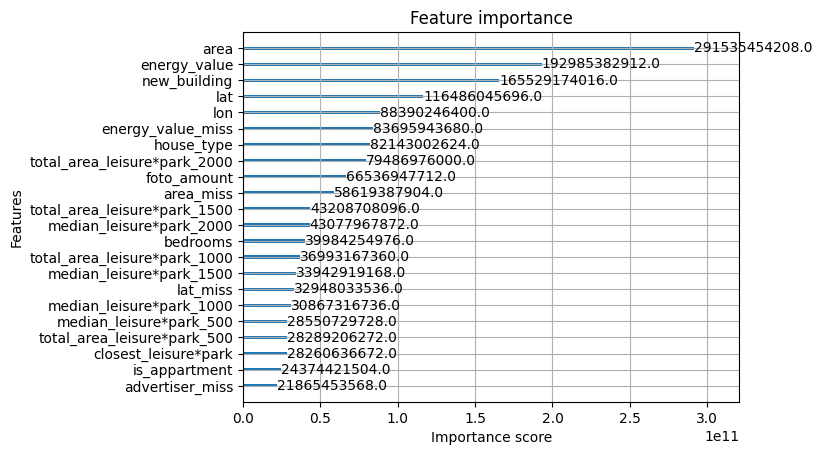

In [30]:
xgb.plot_importance(xgb_regressor, importance_type='gain')

# Test

## Data

In [25]:
# test = pd.read_csv("test.csv", header=0)
test = test.reset_index()
# test = test.drop(columns=['is_promoted','sticker','price_drop_date'])
test['energy_label'] = test['energy_label'].astype('category')
test['new_building'] = test['new_building'].astype('bool')
test['postcode'] = test['postcode'].astype('category')

test['bedrooms_cat'] = pd.cut(test['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
test['house_type'] = test['subtype'].apply(categorize_house)

## KNN

In [ ]:
# X_test = test[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy()

# X_test_encoded = pd.get_dummies(X_test, columns=['house_type'])

# scaler = StandardScaler()
# X_test_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_test_encoded[['area','lat','lon','energy_value','foto_amount']])
# X_test_encoded.isna().apply(sum)
# y_test = test['price'].copy()
# y_pred_test = neigh_model_final.predict(X_test_encoded)

## XGBoost

## Error bars

In [615]:
mean_error_1=(y_pred_test/y_test-1).mean()
error_bound_1 = (y_pred_test/y_test-1).std()/len(y_pred_test)**(1/2)*1.96

mean_error_2=abs(y_pred_test/y_test-1).mean()
error_bound_2 = abs(y_pred_test/y_test-1).std()/(len(y_pred_test)**(1/2))*1.96

mean_error_3=((y_pred_test-y_test)**2).mean()**(1/2)
error_bound_3 = abs(y_pred_test-y_test).std()/(len(y_pred_test)**(1/2))*1.96

# Submission metrics

In [510]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_1-error_bound_1)
y_pred_final['upper']=y_pred_test*(1-mean_error_1+error_bound_1)
y_pred_final['pred']=y_pred_test*(1-mean_error_1)

y_pred_final.to_csv(f"xgb_simple_1.csv", index=False)

In [513]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_2-error_bound_2)
y_pred_final['upper']=y_pred_test*(1+mean_error_2+error_bound_2)
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_2.csv", index=False)

In [512]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=np.maximum(y_pred_test-mean_error_3-error_bound_3,0)
y_pred_final['upper']=y_pred_test+mean_error_3+error_bound_3
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_3.csv", index=False)